# 2. Neural Network Classification with PyTorch

Binary, multi-class, or multi-label classification

1. Binary: Either this or that
2. Multi-class: One out of multiple options
3. Multi-label: One data point can have multiple labels assigned to it

In [2]:
import sklearn
from sklearn.datasets import make_circles

In [3]:
# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples=n_samples,
                    noise=0.03,
                    random_state=42)

In [4]:
len(X), len(y)

(1000, 1000)

In [5]:
X[:5], y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

In [6]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [7]:
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

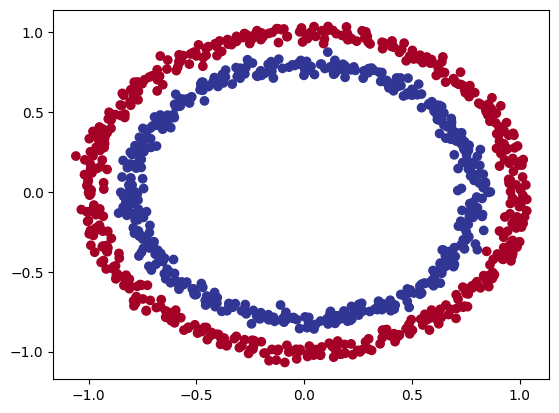

In [8]:
# Visualize the data
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)

**Note:** The dataset here is a "toy dataset"; small enough to experiment with but sizeable enough to practice the fundamentals on.

## 1. Set up the data

### 1.1 Check input and output shapes

In [9]:
X.shape, y.shape

((1000, 2), (1000,))

### 1.2 Separate into train and test tensors

In [10]:
import torch
from torch import nn
torch.__version__

'2.9.1+cu130'

In [11]:
type(X), X.dtype, y.dtype

(numpy.ndarray, dtype('float64'), dtype('int64'))

In [12]:
# Turn into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [13]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [14]:
# Split into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
len(X_train), len(X_test), type(X_train)

(800, 200, torch.Tensor)

## 2. Building a model

1. Set up device agnostic code
2. Construct a model (subclass `nn.Module`)
3. Define loss function and optimizer
4. Create training and testing loops

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [17]:
X_train, X_test = X_train.to(device), X_test.to(device)

In [18]:
y_train, y_test = y_train.to(device), y_test.to(device)

### 2.1 Create the model

1. Create 2 `nn.Linear()` layers capable of handling the shapes of our data
2. Define `forward()` method
3. Instanitate our model class and send to target device

In [19]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # self.layer_1 = nn.Linear(in_features=2, out_features=5, device=device)
        # self.layer_2 = nn.Linear(in_features=5, out_features=1, device=device)
        self.two_linear_layers = nn.Sequential(
            nn.Linear(in_features=2, out_features=5),
            nn.Linear(in_features=5, out_features=1)
        ).to(device=device)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        # return self.layer_2(self.layer_1(X))
        return self.two_linear_layers(X)
    
model_0 = CircleModelV0().to(device=device)
model_0, model_0.state_dict()

(CircleModelV0(
   (two_linear_layers): Sequential(
     (0): Linear(in_features=2, out_features=5, bias=True)
     (1): Linear(in_features=5, out_features=1, bias=True)
   )
 ),
 OrderedDict([('two_linear_layers.0.weight',
               tensor([[ 0.3909,  0.1538],
                       [-0.5863,  0.4353],
                       [ 0.4223,  0.2433],
                       [-0.4369,  0.3407],
                       [ 0.0100, -0.2314]], device='cuda:0')),
              ('two_linear_layers.0.bias',
               tensor([-0.1931, -0.6828, -0.5384, -0.5142, -0.6131], device='cuda:0')),
              ('two_linear_layers.1.weight',
               tensor([[ 0.1405, -0.3349,  0.2600,  0.0369,  0.4371]], device='cuda:0')),
              ('two_linear_layers.1.bias',
               tensor([0.2806], device='cuda:0'))]))

In [20]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [21]:
# # Same model can be created jsut by using nn.Sequential
# model_0 = nn.Sequential(
#     nn.Linear(in_features=2, out_features=5),
#     nn.Linear(in_features=5, out_features=1)
# ).to(device=device)

In [22]:
# model_0, model_0.state_dict()

In [23]:
# next(model_0.parameters()).device

### 2.2 Set up loss function and optimizer

For classification, `nn.L1Loss()` (Mean Absolute Error) or Mean Squared Error will not work since it is for linear regression

For classification, we might need **Binary or Categorical Cross Entropy**

For optimizers, SGD and Adam are the most useful, but there are others too

In [24]:
# Set up the loss function

loss_fn = nn.BCEWithLogitsLoss() # has Sigmoid activation function built-in
# nn.BCELoss() requires inputs to have gone through sigmoid activation before being fed into it

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [ ]:
# Calculate accuracy - (TP+TN)/(TP+TN+FP+FN) - How many are correctly predicted
def accuracy_fn(y_pred, y_true):
    correct = torch.eq(y_pred, y_true).sum().item()
    acc = (correct/len(y_pred))*100
    return acc

## 3. Train model

Training loop:

1. Set up training mode
2. Forward pass on data
3. Calculate loss
4. Zero gradients on optimizer
5. Backpropagation on loss
6. Step the optimizer (gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Model outputs are raw **logits**. Can convert them into **prediction probabilities** by passing them into an **activation function** (e.g. sigmoid, softmax).

Then convert the prediction probabilities to **prediction labels** by rounding them or taking the `argmax()` (for binary and categorical respectively).

In [26]:
# Raw logit output
with torch.inference_mode():
    y_logits = model_0(X_test)[:5]
y_logits

tensor([[-0.1779],
        [-0.0829],
        [-0.1432],
        [-0.1889],
        [ 0.3070]], device='cuda:0')

In [27]:
# Use the sigmoid activation function on logits to to turn them into probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4556],
        [0.4793],
        [0.4643],
        [0.4529],
        [0.5761]], device='cuda:0')

In [28]:
y_preds = torch.round(y_pred_probs)

# Complete flow
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test[:5])))

print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))
y_preds.squeeze()


tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 0., 0., 1.], device='cuda:0')

### 3.2 Building training and testing loops

In [29]:
epochs = 100

for epoch in range(epochs):
    model_0.train()

    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # Calc loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss expects logits, BCELoss expects torch.sigmoid(y_logits)
    acc = accuracy_fn(y_pred=y_pred, y_true=y_train)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    ## Testing
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_pred=test_pred, y_true=y_test)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}")


Epoch: 0 | Loss: 0.70104, Acc: 50.00 | Test loss: 0.70047, Test acc: 51.00
Epoch: 10 | Loss: 0.69865, Acc: 49.62 | Test loss: 0.69866, Test acc: 51.00
Epoch: 20 | Loss: 0.69729, Acc: 50.00 | Test loss: 0.69757, Test acc: 49.50
Epoch: 30 | Loss: 0.69636, Acc: 50.00 | Test loss: 0.69679, Test acc: 49.50
Epoch: 40 | Loss: 0.69567, Acc: 49.75 | Test loss: 0.69619, Test acc: 50.00
Epoch: 50 | Loss: 0.69513, Acc: 49.75 | Test loss: 0.69573, Test acc: 50.50
Epoch: 60 | Loss: 0.69472, Acc: 49.62 | Test loss: 0.69536, Test acc: 49.50
Epoch: 70 | Loss: 0.69439, Acc: 49.75 | Test loss: 0.69508, Test acc: 49.50
Epoch: 80 | Loss: 0.69413, Acc: 49.50 | Test loss: 0.69485, Test acc: 48.00
Epoch: 90 | Loss: 0.69392, Acc: 49.50 | Test loss: 0.69468, Test acc: 50.00
Epoch: 90 | Loss: 0.69392, Acc: 49.50 | Test loss: 0.69468, Test acc: 50.00


## 4. Make predictions and evaluate the model

In [30]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


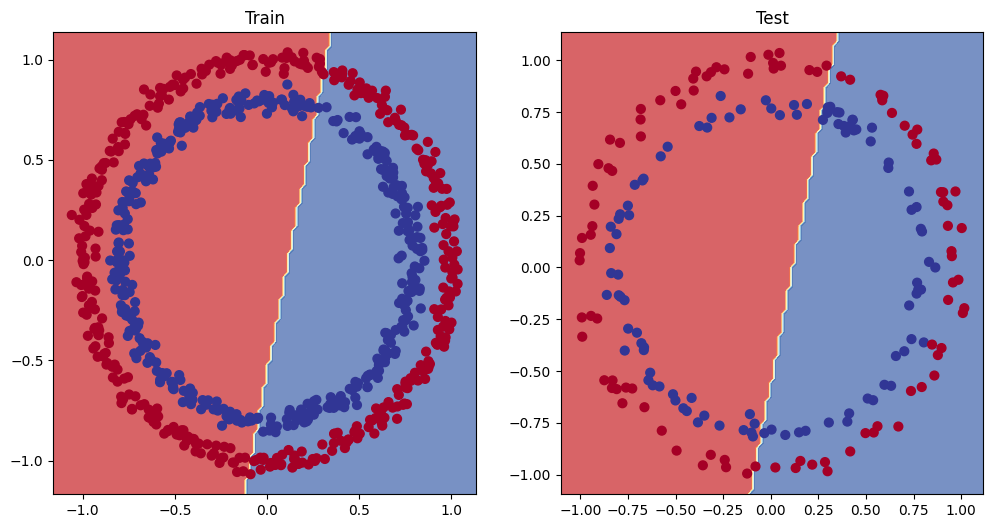

In [31]:
# Plot precision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model

* Add more layers - more chance to learn about patterns in the data
* Add more hidden units
* Train for more epochs
* Change the activation function
* Change the learning rate
* Change the loss function

These are changes we can make **to the model**.

Since these values can be changed by the **experimentor**, these are called hyperparameters.

Change hyperparameters **one by one** so we can track which changes have what effect

In [32]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features=2, out_features=10),
            nn.Linear(in_features=10, out_features=10),
            nn.Linear(in_features=10, out_features=1)
        ).to(device=device)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        return self.layers(X)
    
model_1 = CircleModelV1().to(device=device)
model_1, model_1.state_dict()

(CircleModelV1(
   (layers): Sequential(
     (0): Linear(in_features=2, out_features=10, bias=True)
     (1): Linear(in_features=10, out_features=10, bias=True)
     (2): Linear(in_features=10, out_features=1, bias=True)
   )
 ),
 OrderedDict([('layers.0.weight',
               tensor([[ 0.0434,  0.1969],
                       [-0.0270,  0.3784],
                       [ 0.5471,  0.2909],
                       [-0.5850,  0.6683],
                       [ 0.2458,  0.4639],
                       [ 0.2118, -0.3650],
                       [-0.2493, -0.2272],
                       [-0.4408, -0.5978],
                       [-0.0328, -0.6068],
                       [-0.1356,  0.2577]], device='cuda:0')),
              ('layers.0.bias',
               tensor([ 0.1735,  0.2229, -0.1111,  0.0588,  0.5293, -0.5089, -0.0593, -0.3460,
                       -0.0780, -0.0343], device='cuda:0')),
              ('layers.1.weight',
               tensor([[-0.1710,  0.2421,  0.0785,  0.2041, -0.

In [33]:
# Set up the loss function

loss_fn = nn.BCEWithLogitsLoss() # has Sigmoid activation function built-in
# nn.BCELoss() requires inputs to have gone through sigmoid activation before being fed into it

optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [34]:
epochs = 1000

for epoch in range(epochs):
    model_1.train()

    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # Calc loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss expects logits, BCELoss expects torch.sigmoid(y_logits)
    acc = accuracy_fn(y_pred=y_pred, y_true=y_train)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    ## Testing
    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_pred=test_pred, y_true=y_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}")

Epoch: 0 | Loss: 0.69819, Acc: 49.00 | Test loss: 0.70025, Test acc: 45.00
Epoch: 100 | Loss: 0.69346, Acc: 50.12 | Test loss: 0.69524, Test acc: 50.50
Epoch: 200 | Loss: 0.69307, Acc: 51.00 | Test loss: 0.69471, Test acc: 49.00
Epoch: 300 | Loss: 0.69300, Acc: 50.62 | Test loss: 0.69464, Test acc: 46.50
Epoch: 400 | Loss: 0.69298, Acc: 51.50 | Test loss: 0.69465, Test acc: 47.00
Epoch: 500 | Loss: 0.69298, Acc: 51.00 | Test loss: 0.69466, Test acc: 46.00
Epoch: 600 | Loss: 0.69298, Acc: 51.50 | Test loss: 0.69467, Test acc: 46.00
Epoch: 700 | Loss: 0.69298, Acc: 51.62 | Test loss: 0.69468, Test acc: 45.00
Epoch: 800 | Loss: 0.69298, Acc: 51.25 | Test loss: 0.69468, Test acc: 45.00
Epoch: 900 | Loss: 0.69298, Acc: 51.12 | Test loss: 0.69468, Test acc: 45.50


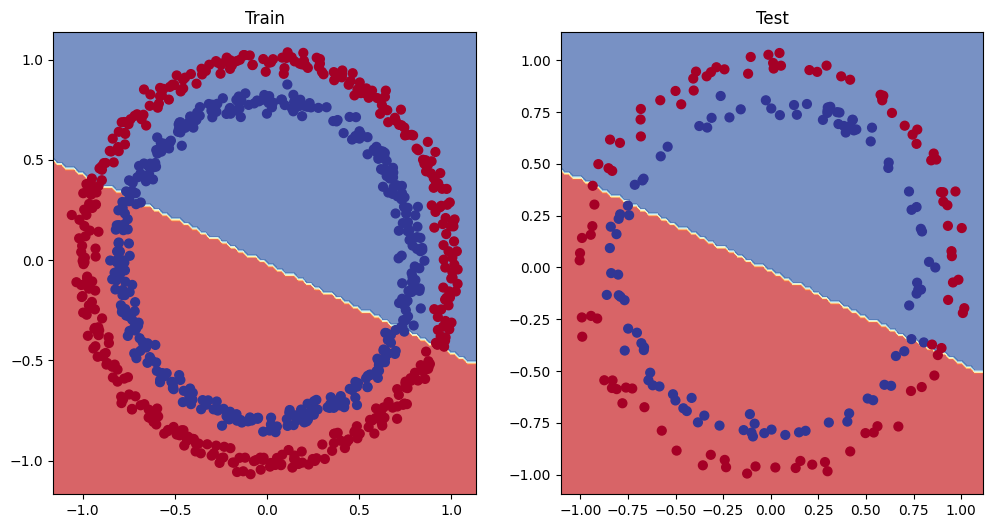

In [35]:
# Plot precision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

## 6. The issue: Non-linear data

The model is made up of linear layers, but the data is non-linear

### 6.1 Recreate the non-linear data

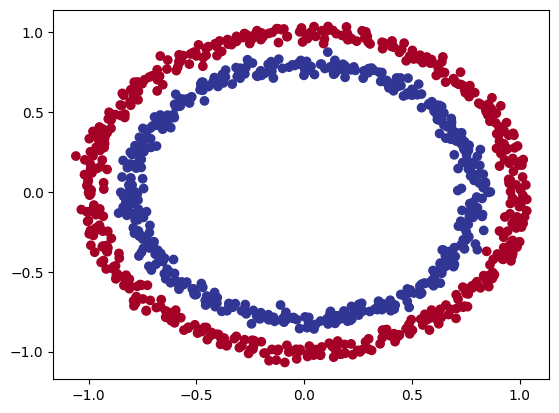

In [36]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=n_samples, noise=0.03, random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [37]:
import torch
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.2)

In [38]:
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

### 6.2 Create a model with non-linear layers 

In [39]:
from torch import nn

class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features=2, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=1),
        )

    def forward(self, X):
        return self.layers(X)
    
model_2 = CircleModelV2().to(device=device)
model_2

CircleModelV2(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
)

### 6.3 Train the model

In [40]:
epochs = 1500

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

for epoch in range(epochs):
    model_2.train()

    y_logits = model_2(X_train).squeeze()

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(torch.round(torch.sigmoid(y_logits)), y_train)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_2.eval()

    with torch.inference_mode():
        test_logits = model_2(X_test).squeeze()
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(torch.round(torch.sigmoid(test_logits)), y_test)

    if epoch % 200 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}")
        



Epoch: 0 | Loss: 0.70089, Acc: 48.00 | Test loss: 0.69600, Test acc: 50.50
Epoch: 200 | Loss: 0.67929, Acc: 58.00 | Test loss: 0.68757, Test acc: 54.50
Epoch: 400 | Loss: 0.65802, Acc: 59.50 | Test loss: 0.67922, Test acc: 54.50
Epoch: 600 | Loss: 0.61193, Acc: 73.50 | Test loss: 0.63522, Test acc: 69.50
Epoch: 800 | Loss: 0.45605, Acc: 94.00 | Test loss: 0.47880, Test acc: 92.00
Epoch: 1000 | Loss: 0.20369, Acc: 99.50 | Test loss: 0.23405, Test acc: 97.88
Epoch: 1200 | Loss: 0.08012, Acc: 100.00 | Test loss: 0.10449, Test acc: 99.38
Epoch: 1400 | Loss: 0.04236, Acc: 100.00 | Test loss: 0.06214, Test acc: 99.75


### 6.4 Evaluate the model

In [41]:
model_2.eval()

with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_2(X_test).squeeze()))

y_preds[:5], y_test[:5]

(tensor([1., 0., 1., 0., 1.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1.], device='cuda:0'))

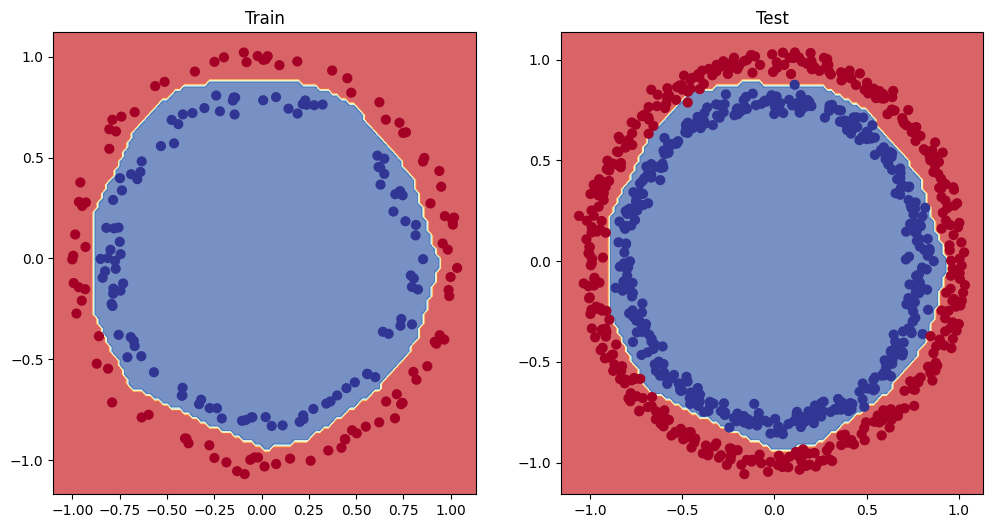

In [42]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_2, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test)

## 7. Replicating non-linear layer

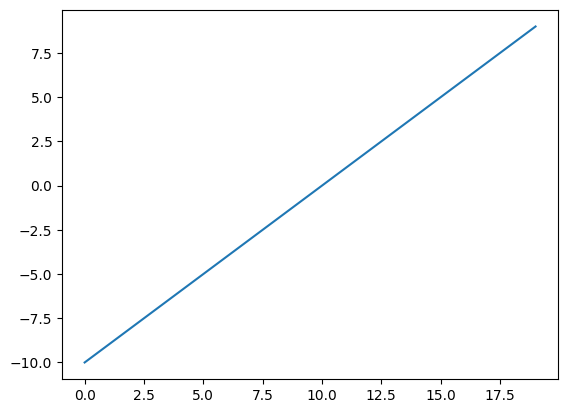

In [43]:
A = torch.arange(-10, 10, 1, dtype=torch.float32)
plt.plot(A)

In [44]:
def relu(X: torch.Tensor) -> torch.Tensor:
    return torch.maximum(torch.tensor(0), X)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

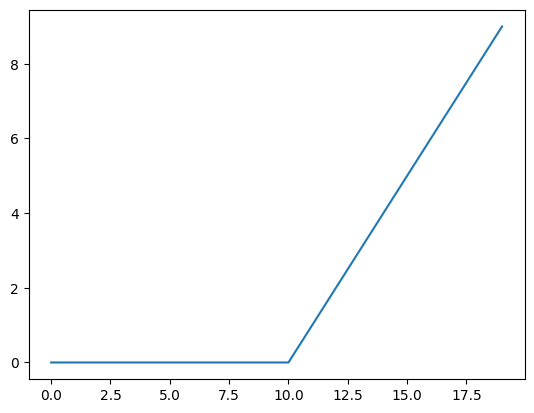

In [45]:
plt.plot(relu(A))

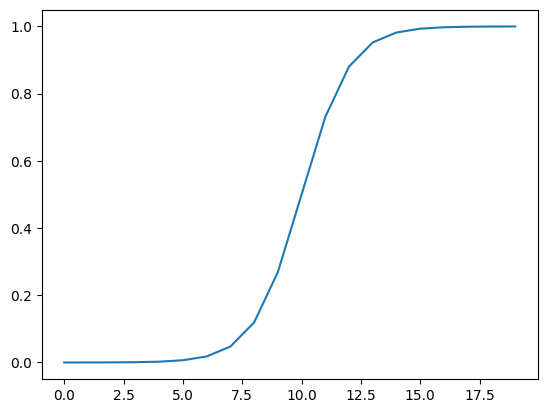

In [46]:
def sigmoid(X: torch.tensor) -> torch.tensor:
    return 1./(1. + torch.exp(-X))

plt.plot(sigmoid(A))

## 8. Multi-class classification problem

### 8.1 Toy multi-class dataset

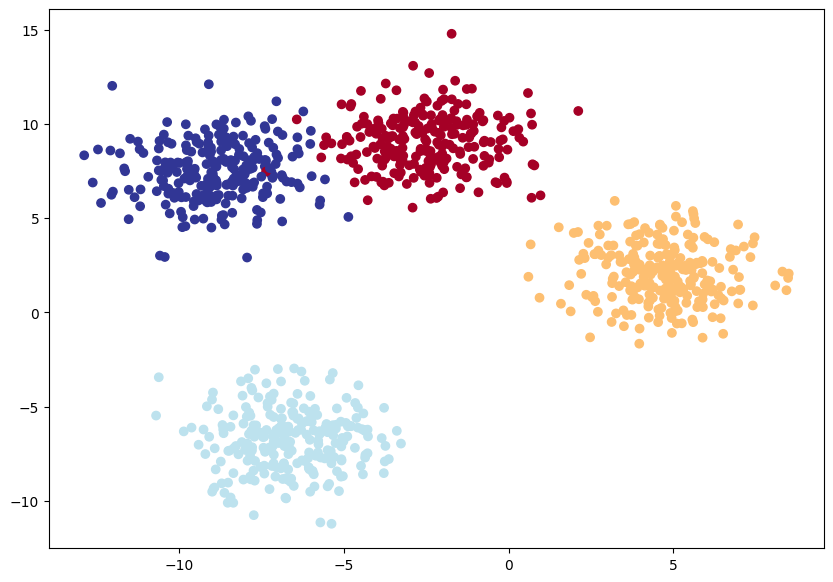

In [214]:
from sklearn.datasets import make_blobs
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

device = "cuda" if torch.cuda.is_available() else "cpu"

# Hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

X_blob = torch.from_numpy(X_blob).type(torch.float32)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 2. Split data
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, train_size=0.8, random_state=RANDOM_SEED)

# 3. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

In [215]:
X_blob_train.shape, y_blob_train[:5]

(torch.Size([800, 2]), tensor([1, 0, 2, 2, 0]))

In [216]:
torch.unique(y_blob_train)

tensor([0, 1, 2, 3])

### 8.2 Building a multi-class classification model

In [217]:
from torch import nn

class BlobModel(nn.Module):
    def __init__(self, in_features, out_features, hidden_units=50, hidden_layers=8, activation=nn.ReLU(), device=None):
        '''
            Initializes multi-class classification model
            Args:
                in_features: input features
                out_features: output features
                hidden_layers: number of hidden layers
        '''
        super().__init__()
        layers = []
        if hidden_layers == 0:
            layers.append(nn.Linear(in_features=in_features, out_features=out_features))
        else:
            # first layer
            layers.append(nn.Linear(in_features=in_features, out_features=hidden_units))
            layers.append(activation)
            # middle hidden layers
            for _ in range(hidden_layers - 1):
                layers.append(nn.Linear(in_features=hidden_units, out_features=hidden_units))
                layers.append(activation)
            # final projection to outputs
            layers.append(nn.Linear(in_features=hidden_units, out_features=out_features))
        
        self.layers = nn.Sequential(*layers)
        if device is not None:
            self.to(device=device)

    def forward(self, X):
        return self.layers(X)

model_4 = BlobModel(2, 4, 50, 5, nn.ReLU(), device)
model_4, model_4.state_dict()

(BlobModel(
   (layers): Sequential(
     (0): Linear(in_features=2, out_features=50, bias=True)
     (1): ReLU()
     (2): Linear(in_features=50, out_features=50, bias=True)
     (3): ReLU()
     (4): Linear(in_features=50, out_features=50, bias=True)
     (5): ReLU()
     (6): Linear(in_features=50, out_features=50, bias=True)
     (7): ReLU()
     (8): Linear(in_features=50, out_features=50, bias=True)
     (9): ReLU()
     (10): Linear(in_features=50, out_features=4, bias=True)
   )
 ),
 OrderedDict([('layers.0.weight',
               tensor([[ 0.3719,  0.5640],
                       [ 0.2121,  0.0347],
                       [-0.4718,  0.5649],
                       [ 0.4595,  0.0566],
                       [ 0.5291, -0.2943],
                       [ 0.4002, -0.5321],
                       [-0.6067, -0.0830],
                       [-0.0226, -0.6595],
                       [ 0.4526, -0.5702],
                       [-0.2917, -0.2522],
                       [-0.0893, -0.5456

### 8.3 Setting up loss function and optimizer

In [218]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_4.parameters(), lr=0.01)

### 8.4 Getting prediction probabilities

In order to evaluate the model, we need to convert model outputs (**logits**) to prediction probabilities and then prediction labels

In [219]:
model_4.eval()

with torch.inference_mode():
    y_logits = model_4(X_blob_test.to(device))

In [220]:
y_pred_probs = torch.softmax(y_logits, dim=1)
y_logits[:5], y_pred_probs[:5]

(tensor([[-0.0205, -0.0476,  0.1155, -0.0354],
         [-0.0203, -0.0194,  0.0783, -0.0284],
         [-0.0044,  0.0011,  0.0654, -0.0456],
         [-0.0143, -0.0352,  0.1111, -0.0395],
         [-0.0346, -0.0492,  0.1177, -0.0424]], device='cuda:0'),
 tensor([[0.2437, 0.2371, 0.2792, 0.2400],
         [0.2441, 0.2443, 0.2694, 0.2421],
         [0.2477, 0.2490, 0.2656, 0.2377],
         [0.2446, 0.2396, 0.2773, 0.2385],
         [0.2414, 0.2379, 0.2811, 0.2395]], device='cuda:0'))

In [221]:
torch.argmax(y_pred_probs[0])

tensor(2, device='cuda:0')

In [222]:
# Convert model prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1).type(torch.float32)
y_preds[:5], y_test[:5]

(tensor([2., 2., 2., 2., 2.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1.], device='cuda:0'))

### 8.5 Create training and testing loops

In [223]:
epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    model_4.train()

    y_logits = model_4(X_blob_train)
    y_probs = torch.softmax(y_logits, dim=1) # may omit, can do argmax directly on logits, same effect
    y_preds = torch.argmax(y_probs, dim=1)

    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_preds, y_blob_train)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_4.eval()

    with torch.inference_mode():
        test_logits = model_4(X_blob_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(test_preds, y_blob_test)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f} | Test loss: {test_loss:.5f}, Test accuracy: {test_acc:.2f}")





Epoch: 0 | Loss: 1.39773, Accuracy: 24.62 | Test loss: 1.27686, Test accuracy: 36.00
Epoch: 10 | Loss: 0.10804, Accuracy: 96.25 | Test loss: 0.01922, Test accuracy: 100.00
Epoch: 20 | Loss: 0.03597, Accuracy: 99.38 | Test loss: 0.00453, Test accuracy: 100.00
Epoch: 30 | Loss: 0.03106, Accuracy: 99.12 | Test loss: 0.00870, Test accuracy: 99.50
Epoch: 40 | Loss: 0.02289, Accuracy: 99.38 | Test loss: 0.01165, Test accuracy: 99.50
Epoch: 50 | Loss: 0.02026, Accuracy: 99.50 | Test loss: 0.01295, Test accuracy: 99.50
Epoch: 60 | Loss: 0.01909, Accuracy: 99.50 | Test loss: 0.00692, Test accuracy: 99.50
Epoch: 70 | Loss: 0.01796, Accuracy: 99.50 | Test loss: 0.00710, Test accuracy: 100.00
Epoch: 80 | Loss: 0.01707, Accuracy: 99.50 | Test loss: 0.00589, Test accuracy: 100.00
Epoch: 90 | Loss: 0.01629, Accuracy: 99.50 | Test loss: 0.00552, Test accuracy: 100.00


### 8.6 Evaluating the model

In [224]:
model_4.eval()

with torch.inference_mode():
    y_logits = model_4(X_blob_test)
    y_preds = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)

y_preds[:5], y_blob_test[:5]

(tensor([1, 3, 2, 1, 0], device='cuda:0'),
 tensor([1, 3, 2, 1, 0], device='cuda:0'))

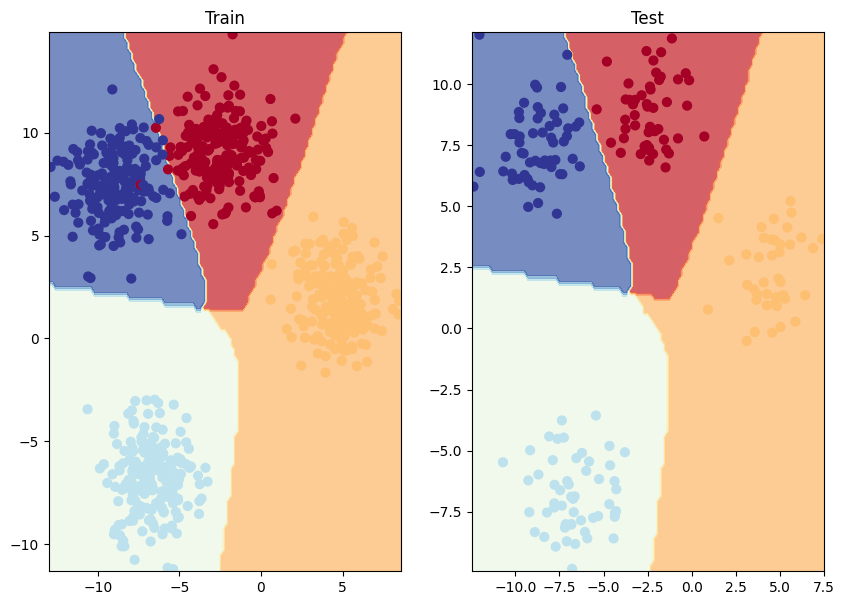

In [225]:
plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

**Note:** Even if we remove the non-linear units from our model, the outputs will be correct, since this data is linearly separable. Although this works in this case, we cannot guarantee that it will work in other cases too.

## 9. A few more classification metrics (to evaluate the classification model)

 For binary classification `TP`/`FP`/`FN`/`TN` denote true/false positives/negatives. For multi-class these metrics are computed per-class and then averaged (macro/micro/weighted).

- **Accuracy**: overall fraction of correct predictions. Not the best for imbalanced classes. `torchmetrics.Accuracy()` or `sklearn.metrics.accuracy_score()`.

  $$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$

- **Precision** (positive predictive value): fraction of predicted positives that are correct. `torchmetrics.Precision()` or `sklearn.metrics.precision_score()`.

  $$Precision = \frac{TP}{TP + FP}$$

- **Recall** (sensitivity, true positive rate): fraction of actual positives that are detected. `torchmetrics.Recall()` or `sklearn.metrics.recall_score()`.

  $$Recall = \frac{TP}{TP + FN}$$

- **F1-score**: harmonic mean of precision and recall. `torchmetrics.F1Score()` or `sklearn.metrics.f1_score()`.

  $$F1 = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall} = \frac{2TP}{2TP + FP + FN}$$

- **Confusion matrix**: counts of true vs predicted labels. `torchmetrics.ConfusionMatrix()`. For binary classification (rows=true, columns=predicted):

  $$\begin{bmatrix} TP & FP \\ FN & TN \end{bmatrix}$$

  For multi-class, the confusion matrix is KxK with row i = true class i and column j = predicted class j.

- **Classification report**: tabular summary (per-class) giving precision, recall, F1 and support; common utilities (e.g., `sklearn.metrics.classification_report`) also provide macro/micro/weighted averages.

Notes:
- Use `nn.CrossEntropyLoss()` for multi-class; it expects class indices (not one-hot).
- When evaluating, compute predicted classes with `torch.argmax` on logits (or softmax probabilities) before deriving per-class TP/FP/FN/TN counts.


In [226]:
from torchmetrics import Accuracy, Precision, Recall, F1Score, ConfusionMatrix

In [230]:
accuracy = Accuracy(task='multiclass', num_classes=4).to(device=device)
precision = Precision(task='multiclass', num_classes=4).to(device=device)
recall = Recall(task='multiclass', num_classes=4).to(device=device)
f1_score = F1Score(task='multiclass', num_classes=4).to(device=device)
confusionMatrix = ConfusionMatrix(task='multiclass', num_classes=4).to(device=device)

In [231]:
print(f"Accuracy: {accuracy(y_preds, y_blob_test)}")
print(f"Precision: {precision(y_preds, y_blob_test)}")
print(f"Recall: {recall(y_preds, y_blob_test)}")
print(f"F1 Score: {f1_score(y_preds, y_blob_test)}")
print(f"Confusion Matrix:\n{confusionMatrix(y_preds, y_blob_test)}")

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
tensor([[49,  0,  0,  0],
        [ 0, 41,  0,  0],
        [ 0,  0, 53,  0],
        [ 0,  0,  0, 57]], device='cuda:0')
